# Задача 1 - оптимизация портфеля акций

## Загрузка данных

Мы будем рассматривать алгоритмы на обрезанном датасете из 4 акций. Решение изначальной задачи для 100 акций может быть сведено к представленному ниже решению, но нами не производилось

In [40]:
!pip install qiskit
!pip install qiskit-algorithms
!pip install qiskit-finance
!pip install qiskit-aer

In [41]:
from qiskit_algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit_finance import QiskitFinanceError
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import warnings
from sympy.utilities.exceptions import SymPyDeprecationWarning
warnings.simplefilter("ignore", SymPyDeprecationWarning)

from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import matplotlib.pyplot as plt
import datetime

### Загрузка данных о цене акций
Данные представленны в виде таблицы (предоставленная в задаче таблица обрезана до четырех первых столбцов, т.е. рассматривается возможность покупки только четырех акций)

In [42]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

In [43]:
from google.colab import drive
drive.mount('/content/drive')

# Загрузка данных

import os
project_dir = '/content/drive/MyDrive/Colab Notebooks/'
url = os.path.join(project_dir, 'task-1-stocks_4.csv')
df = pd.read_csv(url)

df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4 entries, (10.648882865905762, 20.986433029174805, 2.400000095367432, 0.0006000000284984, 2.789999961853028, 76.27999877929688, 48.66471099853516, 33.29999923706055, 106.5669937133789, 0.0768299996852874, 0.0001999999949475, 31.85018539428711, 0.0010999999940395, 0.0076999999582767, 0.1500000059604644, 0.0219999998807907, 133.7638397216797, 9.999999747378752e-05, 20.709999084472656, 26.39114570617676, 52.20442199707031, 130.70469665527344, 12.949999809265137, 183.5534820556641, 156.0373992919922, 133.4199981689453, 107.88322448730467, 76.94000244140625, 333.9274597167969, 571.7899780273438, 186.5947723388672, 71.2486572265625, 228.69381713867188, 227.19000244140625, 71.74485778808594, 80.89761352539062, 18.37508010864257, 81.80249786376953, 67.54439544677734, 167.9458770751953, 223.48016357421875, 116.3099975

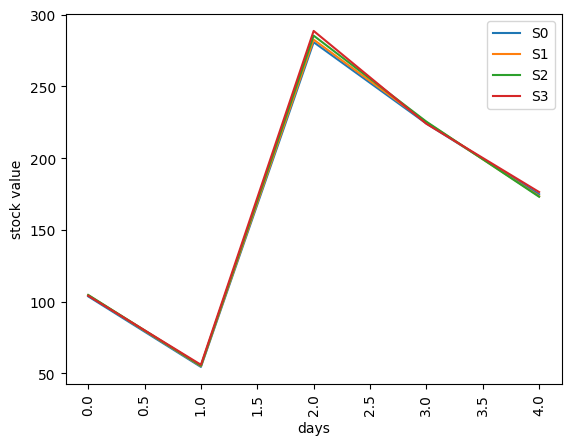

In [44]:
# Let's plot our finanical data
from matplotlib.pyplot import figure
#figure(figsize=(28, 26), dpi=80)

data = np.asarray(df)

for (cnt, s) in enumerate(df.columns[:4]):
    plt.plot(data[cnt][:5], label=s)

plt.legend()
plt.xticks(rotation=90)
plt.xlabel('days')
plt.ylabel('stock value')
plt.show()

## Сведение к QUBO виду

Сузим постановку задачи. Пусть мы имеем возможность купить каждую акцию не более одного раза. В этом случае задачу можно сформулировать в следующем виде:

<div align="center"> <font size=5em >$\min_{x \in \{0, 1\}^n}: $</font> <font color='red', size=5em >$q x^T\Sigma x$</font> - <font color='blue', size=5em>$\mu^T x$</font> </div>

<div align="center"> <font size=5em >$subject$</font> <font size=5em >$to: 1^n x = B$</font> </div>


- <font size=4em >$x$</font> - характеристический вектор множества купленных акций
- <font size=4em >$Σ$</font> (sigma) - матрица ковариации
- <font size=4em >$q$</font> - уровень риска
- <font size=4em >$𝝁$</font> (mu) - ожидаемая доходность акций
- <font size=4em >$n$</font> - число доступных акций
- <font size=4em >$B$</font> - сумма портфеля (бюджет)



Подсчитываем ожидаемую доходность и матрицу корреляции

In [45]:
# Вычисляем дневные доходности
returns = df.pct_change().dropna()
print("Доходности:\n", returns.head())

# Ожидаемую доходность рассчитываем как среднюю доходность за период
mean_returns = returns.mean()
print("Средняя доходность:\n", mean_returns)

# Ковариационная матрица
cov_matrix = returns.cov()
print("Ковариационная матрица:\n", cov_matrix)

mu = np.asarray(mean_returns)
sigma = np.asarray(cov_matrix)

Доходности:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      S0  \
10.584344 21.083

Приведение к QUBO виду можно непосредственно осуществить в соответствии с формулой выше, но мы используем готовое решение из `qiskit-finance`

In [46]:
portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma,
                                  risk_factor=0.2, budget=1000000, bounds=None)
qp = portfolio.to_quadratic_program()

qp.write_to_lp_file(os.path.join(project_dir, "qubo")) # вывод задачи в файл

Дальнейшеее решение нашей командой произведено не было

Файл с выводом выглядит следующим образом
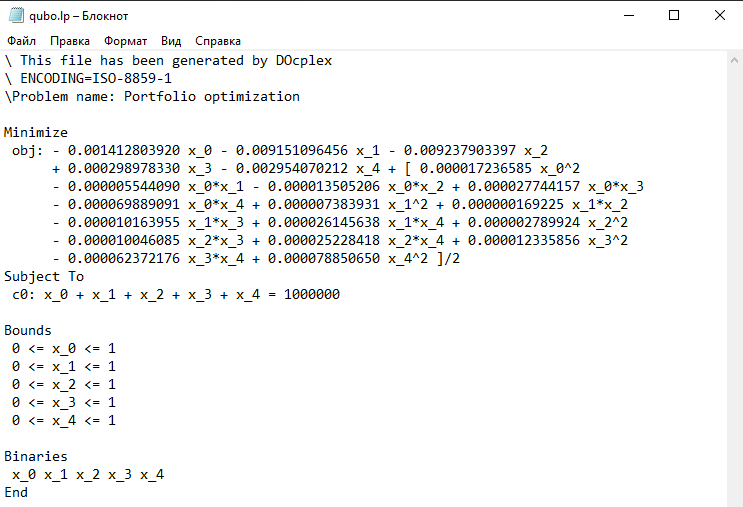

Решить задачу классическим способом можно используя оптимизатор `MinimumEigenOptimizer`, также реализованный в `qiskit`

In [47]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)
result = exact_eigensolver.solve(qp)

print(result)

fval=-0.022443713764875552, x_0=1.0, x_1=1.0, x_2=1.0, x_3=1.0, x_4=1.0, status=INFEASIBLE


## Сведение к задаче о рюкзаке

Другая идея решения этой же задачи состоит в том, чтобы свести  задачу к задаче о рюкзаке и решить ее, используюя QAOA (Quantum Approximate Optimisation Algorithm). Решение задачи о рюкзаке с использованием этого алгоритма подробно описано в статье https://arxiv.org/pdf/1908.02210



### QAOA quantum circuit

In [49]:
from typing import List, Union
import math
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, assemble
from qiskit.compiler import transpile
from qiskit.circuit import Gate
from qiskit.circuit.library.standard_gates import *
from qiskit.circuit.library import QFT

In [50]:
def phase_return(index_qubits: int, gamma: float, L1: list, L2: list, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)

    ### U_1(gamma * (lambda2 - lambda1)) for each qubit ###
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)
    for i, (l1, l2) in enumerate(zip(L1, L2)):
        qc.p(- gamma * (l2 - l1), qr_index[i])

    return qc.to_gate(label=" phase return ") if to_gate else qc


def subroutine_add_const(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(data_qubits)

    ### Phase Rotation ###
    const = const % (2 ** data_qubits)

    for i in range(data_qubits):
        for j in range(data_qubits - i):
            if const >> (data_qubits - 1 - (i + j)) & 1:
                qc.p(math.pi / (2 ** j), i)

    return qc.to_gate(label=" [+"+str(const)+"] ") if to_gate else qc


def const_adder(data_qubits: int, const: int, to_gate=True) -> Union[Gate, QuantumCircuit]:

    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_data)

    appr = 0
    qc.append( QFT(data_qubits, approximation_degree=appr, do_swaps=False, inverse=False, name='QFT').to_gate(), qr_data[::-1] )
    qc.append(subroutine_add_const(data_qubits, const), qr_data)
    qc.append( QFT(data_qubits, approximation_degree=appr, do_swaps=False, inverse=True, name='IQFT').to_gate(), qr_data[::-1] )

    return qc.to_gate(label=" [ +" + str(const) + "] ") if to_gate else qc

def cost_calculation(index_qubits: int, data_qubits: int, list1: list, list2: list, to_gate = True) -> Union[Gate, QuantumCircuit]:

    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qc = QuantumCircuit(qr_index, qr_data)

    approx = 0

    qc.append( QFT(data_qubits, approximation_degree=approx, do_swaps=False, inverse=False, name='QFT').to_gate(), qr_data[::-1] )

    for i, (val1, val2) in enumerate(zip(list1, list2)):

        ### Add val2 using const_adder controlled by i-th index register (set to 1) ###
        qc.append(subroutine_add_const(data_qubits, val2).control(1), [qr_index[i]] + qr_data[:])
        qc.x(qr_index[i])

        ### Add val1 using const_adder controlled by i-th index register (set to 0) ###
        qc.append(subroutine_add_const(data_qubits, val1).control(1), [qr_index[i]] + qr_data[:])
        qc.x(qr_index[i])

    qc.append( QFT(data_qubits, approximation_degree=approx, do_swaps=False, inverse=True, name='IQFT').to_gate(), qr_data[::-1] )

    return qc.to_gate(label=" Cost Calculation ") if to_gate else qc


def constraint_testing(data_qubits: int, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:

    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)

    ### Set the flag register for indices with costs larger than C_max ###
    value_c = 2 ** (data_qubits - 1) - C_max - 1

    qc.append(const_adder(data_qubits, value_c), qr_data)
    qc.append(XGate().control(), [qr_data[0], qr_f])

    return qc.to_gate(label=" Constraint Testing ") if to_gate else qc


def penalty_dephasing(data_qubits: int, alpha: float, gamma: float, to_gate = True) -> Union[Gate, QuantumCircuit]:

    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_data, qr_f)

    ### Phase Rotation ###
    num_carry = 1

    for i in range(data_qubits - num_carry):
        qc.append(PhaseGate(2 ** i * alpha * gamma).control(), [qr_f[:], qr_data[data_qubits - 1 - i]])
    qc.append(PhaseGate(- (2 ** (data_qubits - 1)) * alpha * gamma), qr_f)

    return qc.to_gate(label=" Penalty Dephasing ") if to_gate else qc

def reinitialization(index_qubits: int, data_qubits: int, C1: list, C2: list, C_max: int, to_gate = True) -> Union[Gate, QuantumCircuit]:

    qr_index = QuantumRegister(index_qubits, "index")
    qr_data = QuantumRegister(data_qubits, "data")
    qr_f = QuantumRegister(1, "flag")
    qc = QuantumCircuit(qr_index, qr_data, qr_f)

    ### Reinitialization Circuit ###
    value_c = 2 ** (data_qubits - 1) - C_max - 1
    qc.append(XGate().control(), [qr_data[0], qr_f])
    qc.append(const_adder(data_qubits, value_c).inverse(), qr_data)

    qc.append(cost_calculation(index_qubits, data_qubits, C1, C2).inverse(), qr_index[:] + qr_data[:])


    return qc.to_gate(label=" Reinitialization ") if to_gate else qc


def mixing_operator(index_qubits: int, beta: float, to_gate = True) -> Union[Gate, QuantumCircuit]:

    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)

    ### Mixing Operator ###
    qr_index = QuantumRegister(index_qubits, "index")
    qc = QuantumCircuit(qr_index)

    qc.rx(2 * beta, qr_index)

    return qc.to_gate(label=" Mixing Operator ") if to_gate else qc

In [37]:
def solver_function(L1: list, L2: list, C1: list, C2: list, C_max: int) -> QuantumCircuit:
    # the number of qubits representing answers
    index_qubits = len(L1)

    # the maximum possible total cost
    max_c = sum([max(l0, l1) for l0, l1 in zip(C1, C2)])

    # the number of qubits representing data values can be defined using the maximum possible total cost as follows:
    data_qubits = math.ceil(math.log(max_c, 2)) + 1 if not max_c & (max_c - 1) == 0 else math.ceil(math.log(max_c, 2)) + 2

    qr_index = QuantumRegister(index_qubits, "index") # index register
    qr_data = QuantumRegister(data_qubits, "data") # data register
    qr_f = QuantumRegister(1, "flag") # flag register
    cr_index = ClassicalRegister(index_qubits, "c_index") # classical register storing the measurement result of index register
    qc = QuantumCircuit(qr_index, qr_data, qr_f, cr_index)

    ### initialize the index register with uniform superposition state ###
    qc.h(qr_index)

    p = 5
    alpha = 1
    for i in range(p):

        ### set fixed parameters for each round ###
        beta = 1 - (i + 1) / p
        gamma = (i + 1) / p

        ### return part ###
        qc.append(phase_return(index_qubits, gamma, L1, L2), qr_index)

        ### step 1: cost calculation ###
        qc.append(cost_calculation(index_qubits, data_qubits, C1, C2), qr_index[:] + qr_data[:])

        ### step 2: Constraint testing ###
        qc.append(constraint_testing(data_qubits, C_max), qr_data[:] + qr_f[:])

        ### step 3: penalty dephasing ###
        qc.append(penalty_dephasing(data_qubits, alpha, gamma), qr_data[:] + qr_f[:])

        ### step 4: reinitialization ###
        qc.append(reinitialization(index_qubits, data_qubits, C1, C2, C_max), qr_index[:] + qr_data[:] + qr_f[:])

        ### mixing operator ###
        qc.append(mixing_operator(index_qubits, beta), qr_index)

    ### measure the index ###
    ### since the default measurement outcome is shown in big endian, it is necessary to reverse the classical bits in order to unify the endian ###
    qc.measure(qr_index, cr_index[::-1])

    return qc

In [39]:
print(qc)

NameError: name 'qc' is not defined